In [48]:
import os
import re
import cv2
import numpy as np
import yaml
import matplotlib.pyplot as plt

class Stitcher():
    def __init__(self, initial_config_path = 'stitcher_config.yaml'):
        
        with open(initial_config_path, "r") as file:
            initial_config = yaml.safe_load(file)
        
        # General configuration
        self.input_dir = initial_config["input_dir"]
        self.output_dir = initial_config["output_dir"]
        self.feature_detector_algo = initial_config.get("feature_detector_algo", "SIFT")
        self.matcher_type = initial_config.get("matcher_type", "BF")
        self.plot = initial_config.get("plot", False)
        self.input_images = []

        # Hyperparameters
        self.ratio_test_threshold = initial_config.get("ratio_test_threshold", 0.5)
        self.ransac_threshold = initial_config.get("ransac_threshold", 5.0)

        # SIFT-specific parameters
        sift_config = initial_config.get("sift", {})
        self.sift_nfeatures = sift_config.get("nfeatures", 0)
        self.sift_nOctaveLayers = sift_config.get("nOctaveLayers", 3)
        self.sift_contrastThreshold = sift_config.get("contrastThreshold", 0.04)
        self.sift_edgeThreshold = sift_config.get("edgeThreshold", 10)
        self.sift_sigma = sift_config.get("sigma", 1.6)

        # ORB-specific parameters
        orb_config = initial_config.get("orb", {})
        self.orb_nfeatures = orb_config.get("nfeatures", 2000)
        self.orb_scaleFactor = orb_config.get("scaleFactor", 1.2)
        self.orb_nlevels = orb_config.get("nlevels", 8)
        self.orb_edgeThreshold = orb_config.get("edgeThreshold", 31)
        self.orb_firstLevel = orb_config.get("firstLevel", 0)
        self.orb_WTA_K = orb_config.get("WTA_K", 2)
        
        self.orb_scoreType = (cv2.ORB_HARRIS_SCORE 
                              if orb_config.get("scoreType") == "ORB_HARRIS_SCORE" 
                              else cv2.ORB_FAST_SCORE)
        
        self.orb_patchSize = orb_config.get("patchSize", 31)
        self.orb_fastThreshold = orb_config.get("fastThreshold", 20)

        # Initialize matcher
        if self.matcher_type == "BF":
            norm_type = cv2.NORM_L2 if self.feature_detector_algo == "SIFT" else cv2.NORM_HAMMING
            self.matcher = cv2.BFMatcher(norm_type, crossCheck=False)
        elif self.matcher_type == "FLANN":
            index_params = dict(algorithm=1, trees=5)
            search_params = dict(checks=50)
            self.matcher = cv2.FlannBasedMatcher(index_params, search_params)
        else:
            raise ValueError("Invalid matcher type. Use 'BF' or 'FLANN'.")

    def read_input_dir(self, right_to_left=False):
        image_extensions = {".jpeg", ".jpg", ".png"}
        
        # Filter and sort files by numeric prefix
        files = [f for f in os.listdir(self.input_dir) if os.path.splitext(f)[1].lower() in image_extensions]
        files.sort(key=lambda f: int(re.match(r'(\d+)', f).group()))
        if right_to_left:
            files = files[::-1]
        
        for file in files:
            img = cv2.imread(os.path.join(self.input_dir, file))
            if img is not None:
                self.input_images.append(img)
            else:
                print(f"Could not read image {file} in {self.input_dir}")
        
        if len(self.input_images) < 2:
            raise ValueError("Not enough images in the input directory.")
        else:
            print(f"Found {len(self.input_images)} images in the input directory.")
    
    ## FEATURE DETECTION AND DESCRIPTION
            
    def detect_keypoints_and_descriptors(self):
        
        # Initialize the specified Feature Detector
        if self.feature_detector_algo == "SIFT":
            self.feature_detector = cv2.SIFT_create(
                nfeatures=self.sift_nfeatures,
                nOctaveLayers=self.sift_nOctaveLayers,
                contrastThreshold=self.sift_contrastThreshold,
                edgeThreshold=self.sift_edgeThreshold,
                sigma=self.sift_sigma
            )
        elif self.feature_detector_algo == "ORB":
            self.feature_detector = cv2.ORB_create(
                nfeatures=self.orb_nfeatures,
                scaleFactor=self.orb_scaleFactor,
                nlevels=self.orb_nlevels,
                edgeThreshold=self.orb_edgeThreshold,
                firstLevel=self.orb_firstLevel,
                WTA_K=self.orb_WTA_K,
                scoreType=self.orb_scoreType,
                patchSize=self.orb_patchSize,
                fastThreshold=self.orb_fastThreshold
            )
        else:
            raise ValueError("Invalid feature detector. Use 'SIFT' or 'ORB'.")
        
        # Detect keypoints and compute descriptors for each image
        self.feature_points_and_descriptors = []
        
        for i, img in enumerate(self.input_images):
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            keypoints, descriptors = self.feature_detector.detectAndCompute(gray, None)
            
            if keypoints is not None and descriptors is not None:
                self.feature_points_and_descriptors.append((keypoints, descriptors))
                print(f"Detected {len(keypoints)} keypoints in image {i+1} using {self.feature_detector_algo}.")
                
                if self.plot:
                    self.plot_features(img, keypoints, title=f"Keypoints in Image {i+1}")
            else:
                print(f"Failed to detect keypoints in image {i+1}")
        print("Feature detection completed.")
        
    
    def plot_features(self, img, keypoints, title="Detected Keypoints"):
        img_with_keypoints = cv2.drawKeypoints(img, keypoints, None, flags=cv2.DrawMatchesFlags_DRAW_RICH_KEYPOINTS)
        plt.figure(figsize=(10, 7))
        plt.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis("off")
        plt.show()
        
    def sift_vs_orb(self):
        pass
    
    
    ## FEATURE MATCHING 
    
    
    def match_features(self, descriptors1, descriptors2):
        matches = self.matcher.knnMatch(descriptors1, descriptors2, k=2)
        good_matches = self.ratio_test(matches)
        print(f"Found {len(good_matches)} good matches after ratio test.")
        return good_matches
    
    def ratio_test(self, matches):
        good_matches = [m for m, n in matches if m.distance < self.ratio_test_threshold * n.distance]
        return good_matches

    def ransac(self):
        pass

    def plot_matches(self, img1, img2, kp1, kp2, good_matches):
        img_matches = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.figure(figsize=(15, 10))
        plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
        plt.title("Feature Matches")
        plt.axis("off")
        plt.show()


    ## IMAGE ALIGNMENT AND STITCHING

    def align_and_stitch_images(self):
        # Initialize the first image as the base for stitching
        result_img = self.input_images[0]
        
        for i in range(len(self.input_images) - 1):
            img1 = result_img
            img2 = self.input_images[i + 1]
            
            kp1, des1 = self.feature_points_and_descriptors[i]
            kp2, des2 = self.feature_points_and_descriptors[i + 1]
            
            # Match features between the current base image and the next image
            good_matches = self.match_features(des1, des2)
            
            if self.plot:
                self.plot_matches(img1, img2, kp1, kp2, good_matches)
            
            # Obtain homography matrix to transform img2 to align with img1
            points1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            points2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
            
            H, _ = cv2.findHomography(points2, points1, cv2.RANSAC, self.ransac_threshold)
            
            # Warp img2 to align with img1 and create a larger canvas for stitching
            height, width = img1.shape[:2]
            img2_warped = cv2.warpPerspective(img2, H, (width + img2.shape[1], height))
            
            # Copy img1 onto the warped canvas
            img2_warped[0:height, 0:width] = img1
            result_img = img2_warped
            
            if self.plot:
                self.plot_stitched_image(result_img, title=f"Stitched Panorama after image {i + 2}")

        # Save the final stitched image
        output_path = os.path.join(self.output_dir, "stitched_panorama.jpg")
        cv2.imwrite(output_path, result_img)
        print(f"Stitched panorama saved at {output_path}")


    def plot_stitched_image(self, image, title="Stitched Panorama"):
        plt.figure(figsize=(15, 10))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis("off")
        plt.show()



In [49]:
# Creating a Stitcher object with required specifications

stitcher = Stitcher()
stitcher.read_input_dir(right_to_left=True)

Found 3 images in the input directory.


## Step 1 - Feature Detection and Description
- Using SIFT or ORB

### ORB Features - 

Detected 2000 keypoints in image 1 using ORB.


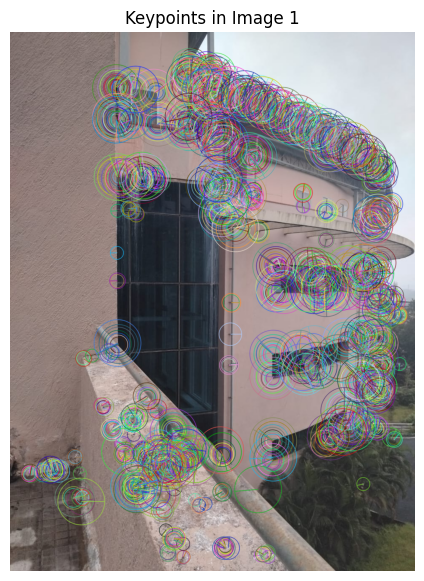

Detected 2000 keypoints in image 2 using ORB.


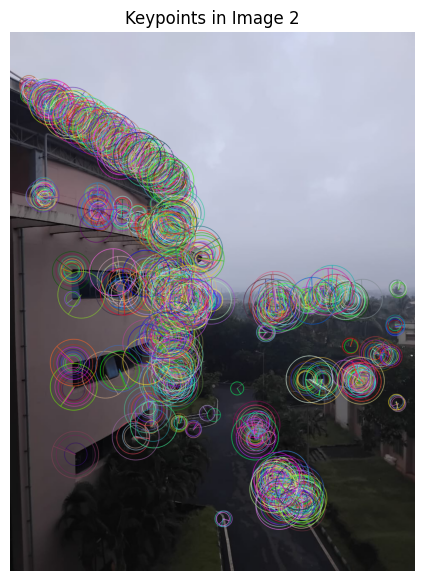

Detected 2000 keypoints in image 3 using ORB.


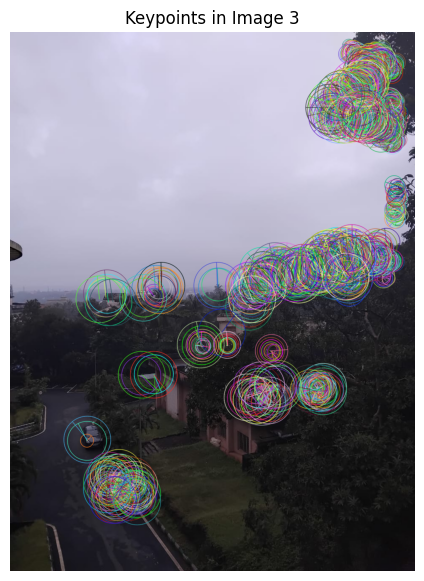

Feature detection completed.


In [50]:
stitcher.feature_detector_algo = "ORB"
stitcher.detect_keypoints_and_descriptors()

Detected 2921 keypoints in image 1 using SIFT.


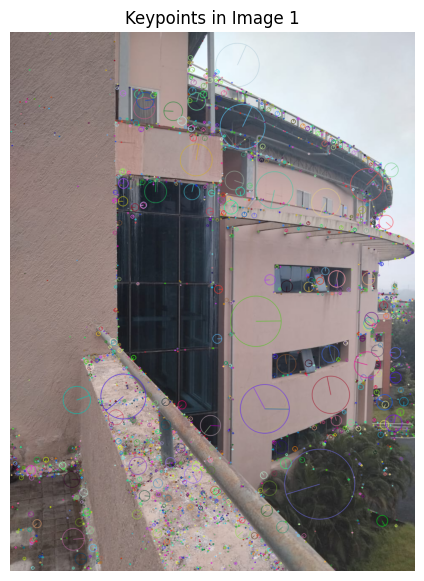

Detected 1213 keypoints in image 2 using SIFT.


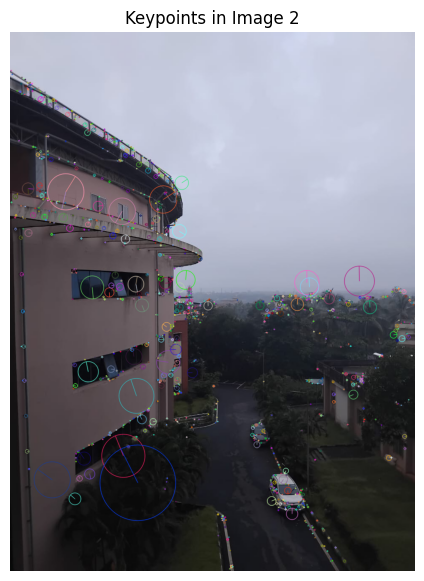

Detected 1659 keypoints in image 3 using SIFT.


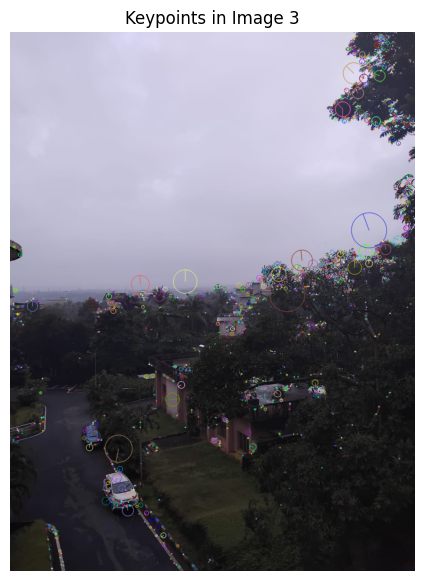

Feature detection completed.


In [51]:
stitcher.feature_detector_algo = "SIFT"
stitcher.detect_keypoints_and_descriptors()

Found 152 good matches after ratio test.


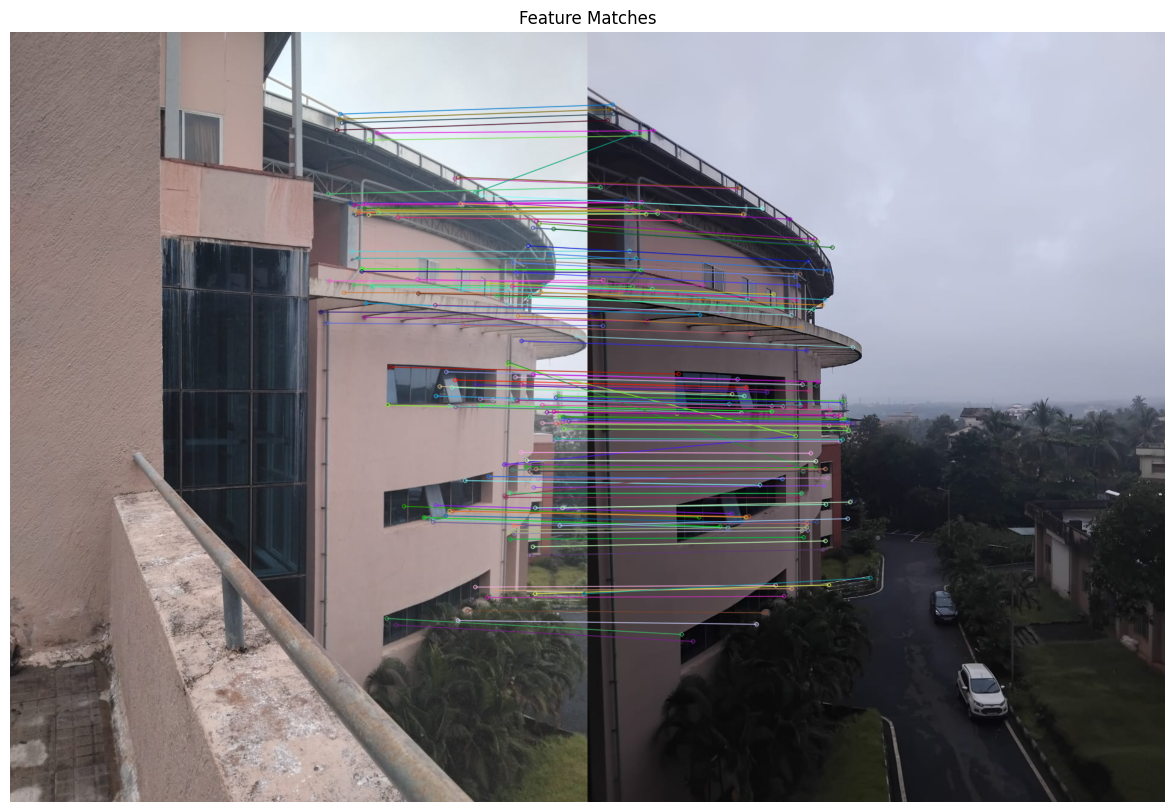

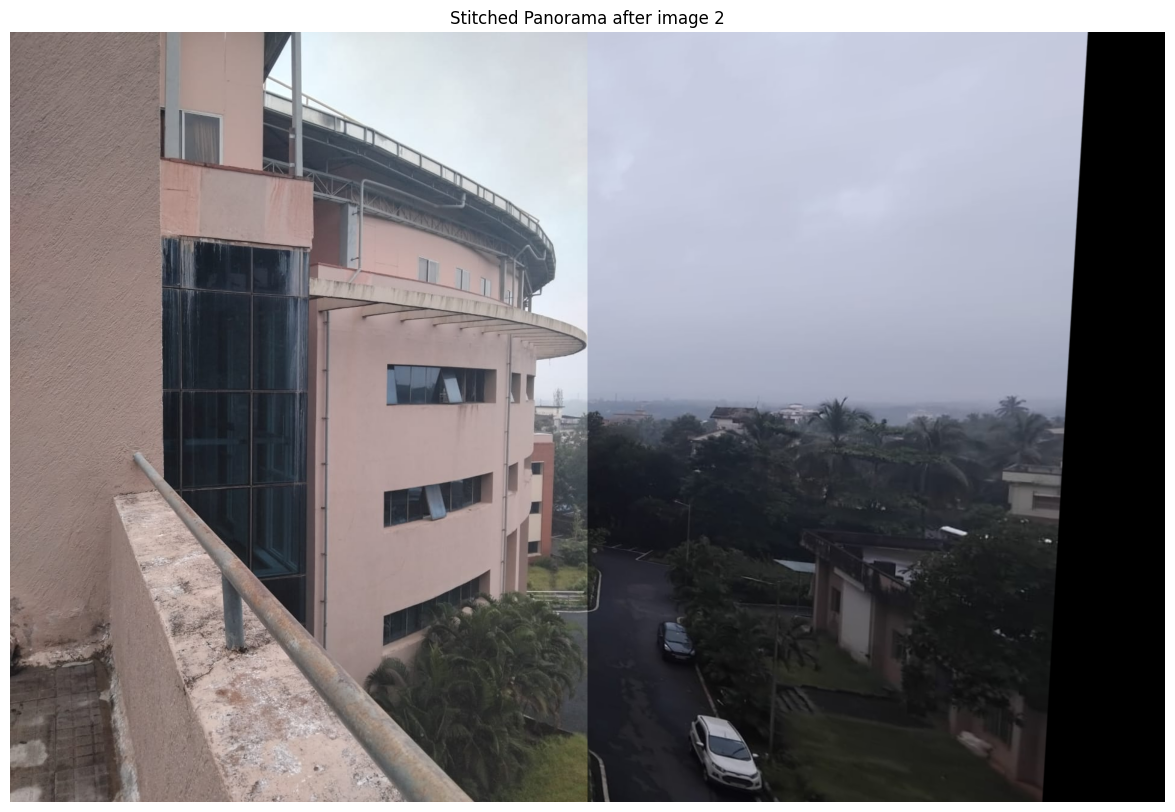

Found 110 good matches after ratio test.


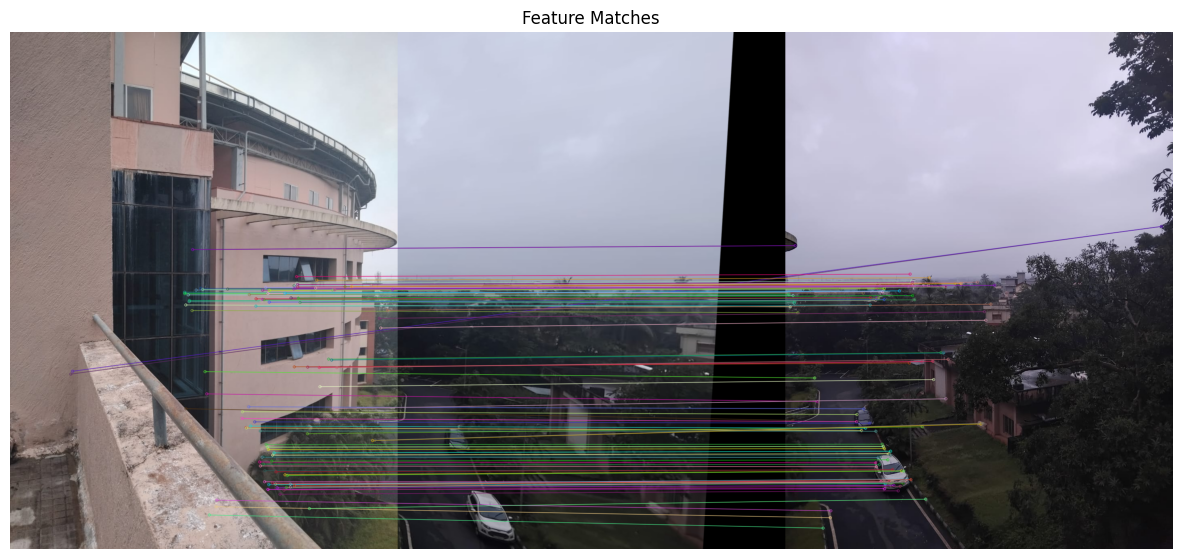

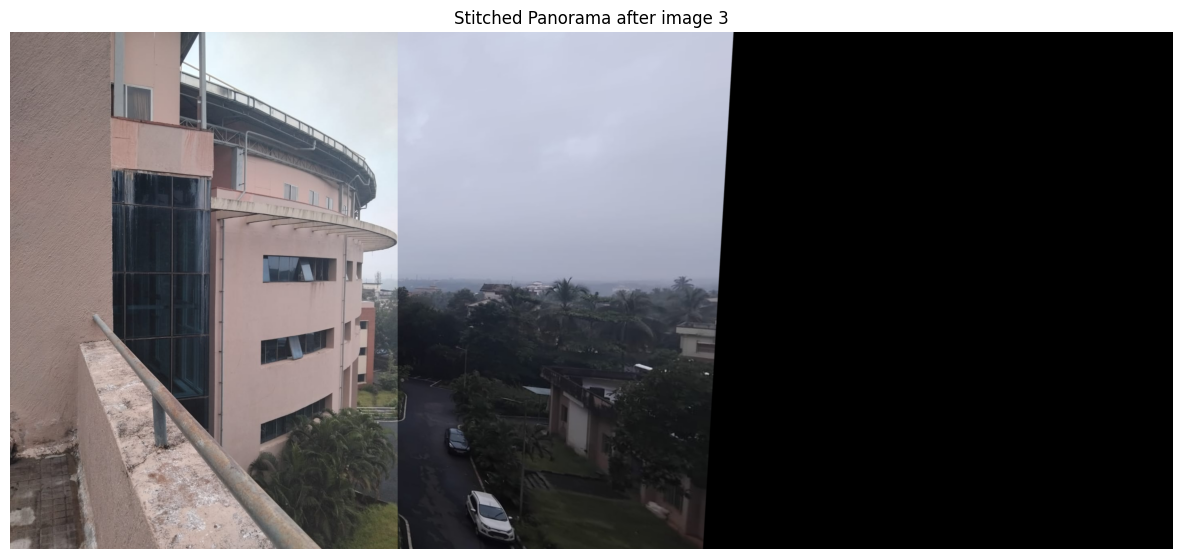

Stitched panorama saved at data/outputs/stitched_panorama.jpg


In [8]:
stitcher.align_and_stitch_images()